<a href="https://colab.research.google.com/github/iskra3138/ImageSr/blob/master/Adaptive_Threshold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

본 colab 노트는 목표 누출률을 meet시키는 adaptive threshold를 찾은 후, adpative threshold에 따라 prediction을 한 후, OK 필터율을 계산하는 코드로 아래 3가지 종료의 함수로 구성되어 있습니다.
- 결과를 출력하는 함수(모양에 따라 2가지): `print_results1`, `print_results2`
- adaptive threshold를 찾는 함수: `make_adpative_threshold`
- adpative threshold에 따라 prediction을 하는 함수: `make_new_preds`

모델이 예측한 softmax array(num_data * num_class)와 GT one-hot array(num_data * num_class)가 필요하며, OK Class는 0번 column에 위치하여야 합니다. 

adative threshold를 찾고 새롭게 prediction 하는 logic은 다음과 같습니다.
- 누출률이 FP 값에 관련되어 있으므로, 요구되는 누출률을 만족하는 가장 큰 FP값인 FP_sup을 구합니다. (35,000장에 0.01%일 경우 3)
- FP에 해당되는 데이터들에 대해 OK Class값을 descending order한 후, FP_sup 번째 해당되는 OK Class의 softmax값을 adative threshold로 결정합니다.
- 그리고 OK의 softmax값이 adaptive threshold보다 클 경우에만 OK로 예측합니다. 이를 통해 FP_sup 개수 만큼만 FP에 위치하게 됩니다.
- OK의 softmax값이 adaptive threshold보다 작을 경우에는 NG Classes중 argmax에 해당되는 class를 결과값으로 예측합니다.
- 새롭게 예측된 TP값을 이용해 OK필터율을 계산합니다.

In [1]:
import pandas as pd
import numpy as np
from scipy.special import softmax
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 함수 정의

- 결과를 출력할 함수는 Confusion Matrix 모양에 따라 2가지 함수를 정의하였습니다.

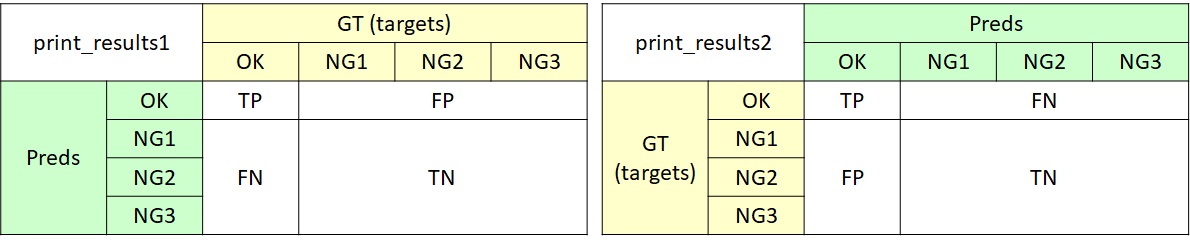

In [2]:
def print_results1(targets, preds, th=None, classname=None) :
  cm = confusion_matrix(preds, targets)
  if th == None:
    print ('default_threshold is applied')
  else :
    print ("adaptive_threshold: {:.3f} is applied".format(ad_th))
  if classname == None:
    print (classification_report(targets, preds))
  else:
    print (classification_report(targets, preds, target_names=classname))
  print ("Accuracy: {:.3f}% ".format(100*accuracy_score(targets, preds)))
  print ('##### Confusion Matrix #####')
  print (cm)
  print ("leakage rate: {:.3f}% ".format(100*(cm[0][1:].sum()/targets.shape[0])))
  print ("OK filter rate: {:.3f}%".format(100*(cm[0][0]/targets.shape[0])))

In [3]:
def print_results2(targets, preds, th=None, classname=None) :
  cm = confusion_matrix(targets, preds)
  if th == None:
    print ('default_threshold is applied')
  else :
    print ("adaptive_threshold: {:.3f} is applied".format(ad_th))
  if classname == None:
    print (classification_report(targets, preds))
  else:
    print (classification_report(targets, preds, target_names=classname))
  print ("Accuracy: {:.3f}% ".format(100*accuracy_score(targets, preds)))
  print ('##### Confusion Matrix #####')
  print (cm)
  print ("leakage rate: {:.3f}% ".format(100*(cm[:,0][1:].sum()/targets.shape[0])))
  print ("OK filter rate: {:.3f}%".format(100*(cm[:,0][0]/targets.shape[0])))

In [4]:
def make_adpative_threshold(probs, labels, leakage_rate) :
  '''
  adaptive_threshold 구하는 함수

  inputs:
      probs: 모델이 예측한 2-D softmax array(num_data*num_class)
      labels: GT 2-D one-hot array(num_data*num_class)
      leakage_rate: 목표 누출율
  returns:
      ad_th: 목표 누출율을 meet하기 위한 threshold
  '''
  targets = np.argmax(labels, axis=1)
  preds = np.argmax(probs, axis=1)

  loc_gt_ng = np.where(targets!=0) # GT가 NG인 데이터들의 위치값 구하기
  loc_ai_ok = np.where(preds==0) # preds가 OK인 데이터들의 위치값 구하기
  loc_fp = np.intersect1d(loc_gt_ng, loc_ai_ok) # fp에 해당되는 데이터들의 위치값 구하기

  fp_sup = np.trunc(labels.shape[0] * leakage_rate / 100) # 허용 가능한 fp중 상한값 구하기  
  fp_sup = fp_sup.astype(int) # index로 사용하기 위해 integer로 바꾸기

  ad_th = np.sort(probs[loc_fp][:,0])[-fp_sup]
  return ad_th

In [5]:
def make_new_preds(probs, ad_th) :
  '''
  새로운 adaptive_thresholod를 적용하여 preds값을 새로 계산하는 함수

  inputs:
      probs: 모델이 예측한 2-D softmax array(num_data*num_class)
      ad_th: 목표 누출율을 meet하기 위한 threshold
  returns:
      new_preds: ad_th를 적용해서 새롭게 예측된 결과
  '''
  new_probs = np.copy(probs) # 새로운 prediction을 위한 probs array copy

  loc_ok = np.where(new_probs[:,0] >= ad_th) # ad_th보다 크거나 같을 경우
  new_probs[:,0][loc_ok] = 1.0 # argmax결과가 반드시 OK가 되도록 ok softmax값을 1로 설정 

  loc_ng = np.where(new_probs[:,0] < ad_th) # ad_th보다 작을 경우, 
  new_probs[:,0][loc_ng] = 0 # argmax 결과가 절대 OK가 되지 못하도록 ok softmax값을 0으로 설정

  new_preds = np.argmax(new_probs, axis=1)
  return new_preds

# CODE TEST

- Classname은 반드시 필요한 변수는 아닙니다. classification_report 결과를 출력할 때만 사용합니다. 
- leakage_rate은 반드시 필요합니다.

In [6]:
classname = ['OK', 'NG1','NG2', 'NG3'] # Multi classification일 때, Class 정보, 항상 OK가 첫번째 위치해야 함
#classname = ['OK', 'NG'] # Binary Classification일 때, Class 정보, 항상 OK가 첫번째 위치해야 함
leakage_rate = 0.01 # adpative threshold 구할 때 필요한 누출률(%)

### Synthetic dataset 생성
- code test를 위해 가상의 모델 예측결과 데이터와 GT 데이터를 생성합니다.
- 실제 적용 시에는 model이 예측한 softmax 값들로 구성된 `probs`와 GT가 one-hot vector로 구성된 `labels`가 있어야 합니다.

In [7]:
# code test를 위한 Syentic result 생성
num_data = 35000 # 총 테스트 데이터 개수
num_class = len(classname)

# prediction값 `probs` 만들기
logits = np.random.rand(num_data, num_class)
probs = softmax(logits, axis=1)
#print (np.sum(probs,axis=1), probs.shape)
print(probs.shape)

# GT Data `labels` 만들기
targets = np.random.randint(num_class, size=num_data)
labels = np.eye(num_class)[targets]
print (labels.shape)

(35000, 4)
(35000, 4)


### adaptive threshold를 적용하기 전 결과를 출력합니다.

In [8]:
targets = np.argmax(labels, axis=1)
preds = np.argmax(probs, axis=1)
print_results1(targets, preds, classname=classname)

default_threshold is applied
              precision    recall  f1-score   support

          OK       0.25      0.25      0.25      8694
         NG1       0.25      0.25      0.25      8680
         NG2       0.26      0.26      0.26      8711
         NG3       0.25      0.24      0.25      8915

    accuracy                           0.25     35000
   macro avg       0.25      0.25      0.25     35000
weighted avg       0.25      0.25      0.25     35000

Accuracy: 25.049% 
##### Confusion Matrix #####
[[2149 2135 2169 2223]
 [2167 2165 2146 2264]
 [2162 2163 2273 2248]
 [2216 2217 2123 2180]]
leakage rate: 18.649% 
OK filter rate: 6.140%


### 누출률을 맞추기 위한 adpative threshold를 구하고 preds값을 새로 계산하여 confusion matrix와 OK 필터율을 출력합니다.

In [9]:
ad_th = make_adpative_threshold(probs, labels, leakage_rate)
targets = np.argmax(labels, axis=1)
new_preds = make_new_preds(probs, ad_th)

In [10]:
print_results1(targets, new_preds, th=ad_th, classname=classname)

adaptive_threshold: 0.444 is applied
              precision    recall  f1-score   support

          OK       0.25      0.00      0.00      8694
         NG1       0.25      0.33      0.28      8680
         NG2       0.26      0.35      0.29      8711
         NG3       0.25      0.33      0.28      8915

    accuracy                           0.25     35000
   macro avg       0.25      0.25      0.22     35000
weighted avg       0.25      0.25      0.22     35000

Accuracy: 25.129% 
##### Confusion Matrix #####
[[   1    1    1    1]
 [2881 2879 2857 3005]
 [2876 2872 3014 3008]
 [2936 2928 2839 2901]]
leakage rate: 0.009% 
OK filter rate: 0.003%
